In [1]:
%pip install -q -r requirements.txt
import sys
print(f"Python {sys.version}")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from myo_utils import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.figsize'] = FIGURE_SIZE

Note: you may need to restart the kernel to use updated packages.
Python 3.11.14 | packaged by conda-forge | (main, Jan 26 2026, 23:39:55) [MSC v.1944 64 bit (AMD64)]


In [2]:
train, train_labels, valid, valid_labels, test, test_labels = load_data_curated()

../myo-readings-dataset/_readings_right_hand/12345-1\0.txt
../myo-readings-dataset/_readings_right_hand/12345-1\1.txt
../myo-readings-dataset/_readings_right_hand/12345-1\2.txt
../myo-readings-dataset/_readings_right_hand/12345-1\3.txt
../myo-readings-dataset/_readings_right_hand/12345-1\4.txt
../myo-readings-dataset/_readings_right_hand/12345-1\5.txt
../myo-readings-dataset/_readings_right_hand/12345-1\6.txt
../myo-readings-dataset/_readings_right_hand/12345-1\7.txt
../myo-readings-dataset/_readings_right_hand/21547-1\0.txt
../myo-readings-dataset/_readings_right_hand/21547-1\1.txt
../myo-readings-dataset/_readings_right_hand/21547-1\2.txt
../myo-readings-dataset/_readings_right_hand/21547-1\3.txt
../myo-readings-dataset/_readings_right_hand/21547-1\4.txt
../myo-readings-dataset/_readings_right_hand/21547-1\5.txt
../myo-readings-dataset/_readings_right_hand/21547-1\6.txt
../myo-readings-dataset/_readings_right_hand/21547-1\7.txt
../myo-readings-dataset/_readings_right_hand/45612-1\0.t

In [3]:
# train, train_labels, valid, valid_labels, test, test_labels = load_data_all()

In [4]:
# Regenerate curated.txt: trains a small model per participant, keeps those above threshold.
# Uses myo_utils defaults: READINGS_DIR, CURATED_FILE, CURATION_ACCURACY_THRESHOLD.
# Optional: generate_curated(readings_dir=..., output_file=..., accuracy_threshold=...)
# generate_curated()

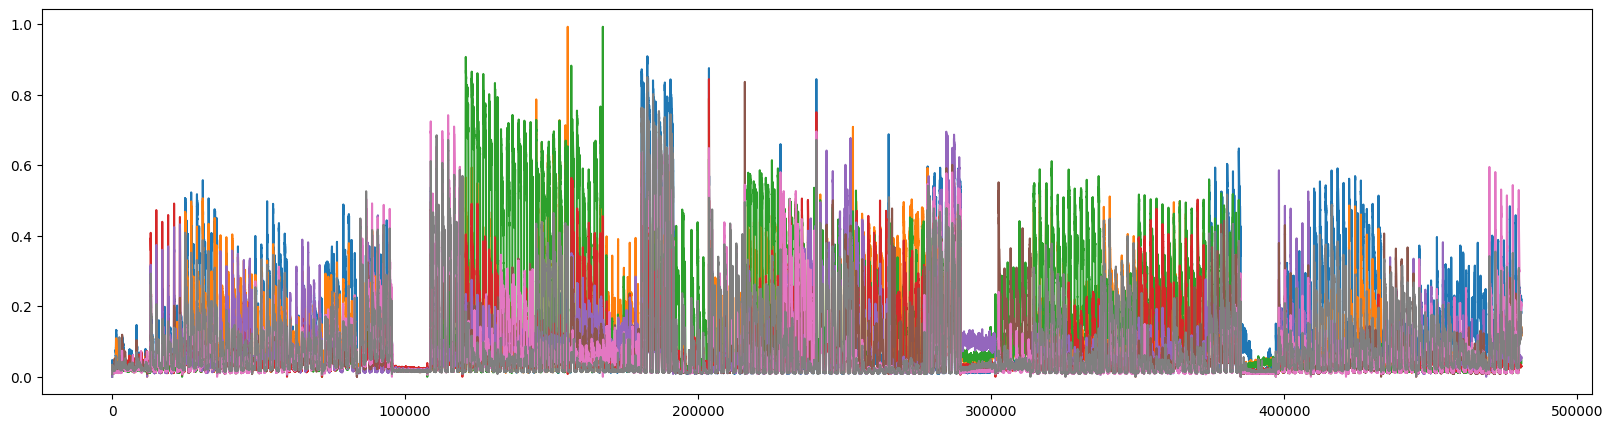

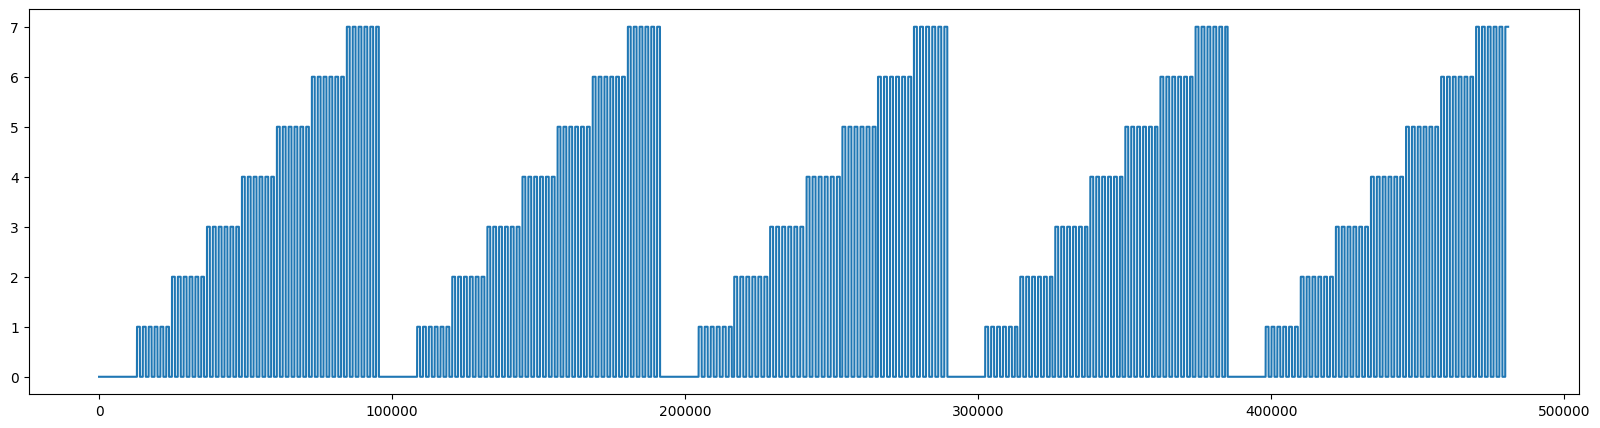

In [5]:
plt.figure()
plt.plot(train)
plt.figure()
plt.plot(train_labels)

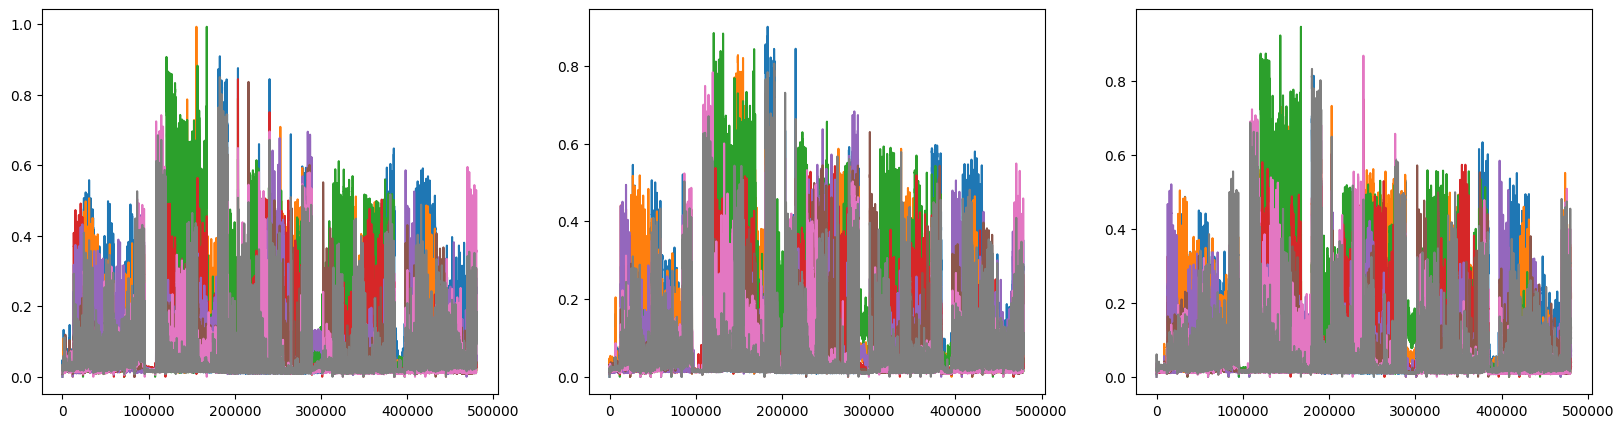

In [6]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(train)
ax[1].plot(valid)
ax[2].plot(test)

In [7]:
model = keras.Sequential([
    keras.layers.Input(shape=(NUM_EMG_CHANNELS,)),
    keras.layers.Dense(LAYER_SIZES[0], activation = "relu"),
    keras.layers.Dense(LAYER_SIZES[1], activation = "relu"),
    keras.layers.Dense(LAYER_SIZES[2], activation = "relu"),
    keras.layers.Dense(NUM_GESTURES, activation = "sigmoid")
])

opt = keras.optimizers.Adam(learning_rate = LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer = opt, loss = loss, metrics = ["accuracy"])

## Training

Fit with early stopping on validation loss and save weights each epoch; after training, the best weights (from the checkpoint) are loaded.

In [8]:
model_checkpoint = ModelCheckpoint(WEIGHTS_FILE, save_weights_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = PATIENCE)
history = model.fit(train, train_labels, 
                    validation_data = (valid, valid_labels), 
                    epochs = EPOCHS, 
                    callbacks = [early_stopping, model_checkpoint])
model.load_weights(WEIGHTS_FILE)

Epoch 1/20
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.8981 - loss: 0.3714 - val_accuracy: 0.8276 - val_loss: 0.6195
Epoch 2/20
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.9295 - loss: 0.2540 - val_accuracy: 0.8239 - val_loss: 0.6853
Epoch 3/20
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.9365 - loss: 0.2195 - val_accuracy: 0.8326 - val_loss: 0.7460
Epoch 4/20
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.9411 - loss: 0.1961 - val_accuracy: 0.8189 - val_loss: 0.8345
Epoch 5/20
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.9450 - loss: 0.1791 - val_accuracy: 0.8249 - val_loss: 0.8769
Epoch 6/20
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.9480 - loss: 0.1648 - val_accuracy: 0.8132 - val_loss: 0.9919


$\mathcal{L}_{\text{train}}$ and $\mathcal{L}_{\text{val}}$ over epochs. A growing gap suggests overfitting.

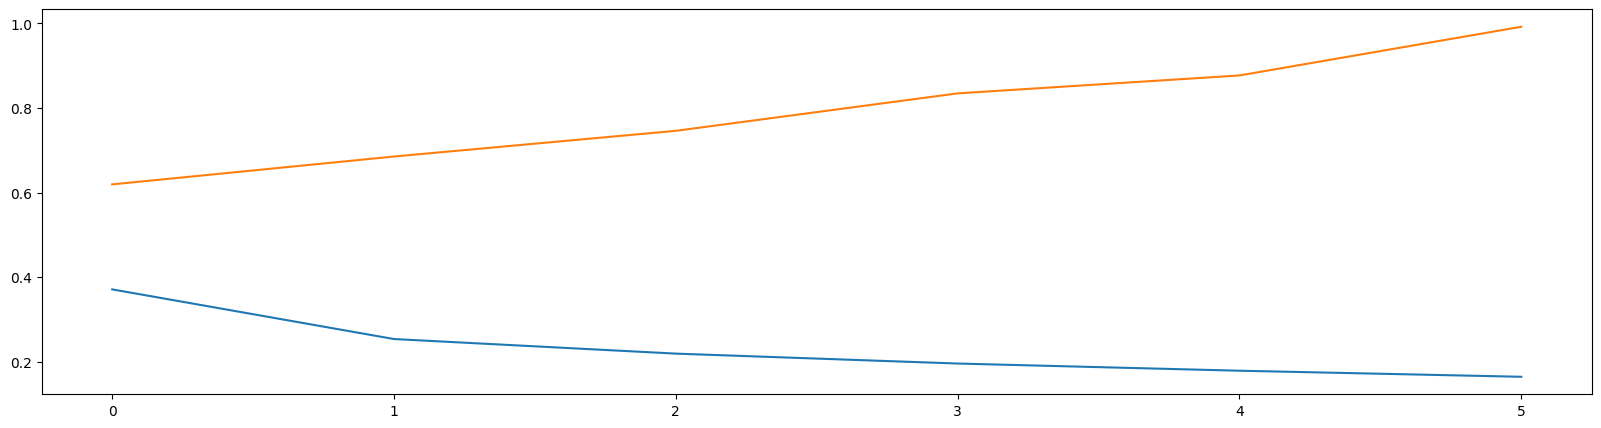

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Training vs validation accuracy over epochs.

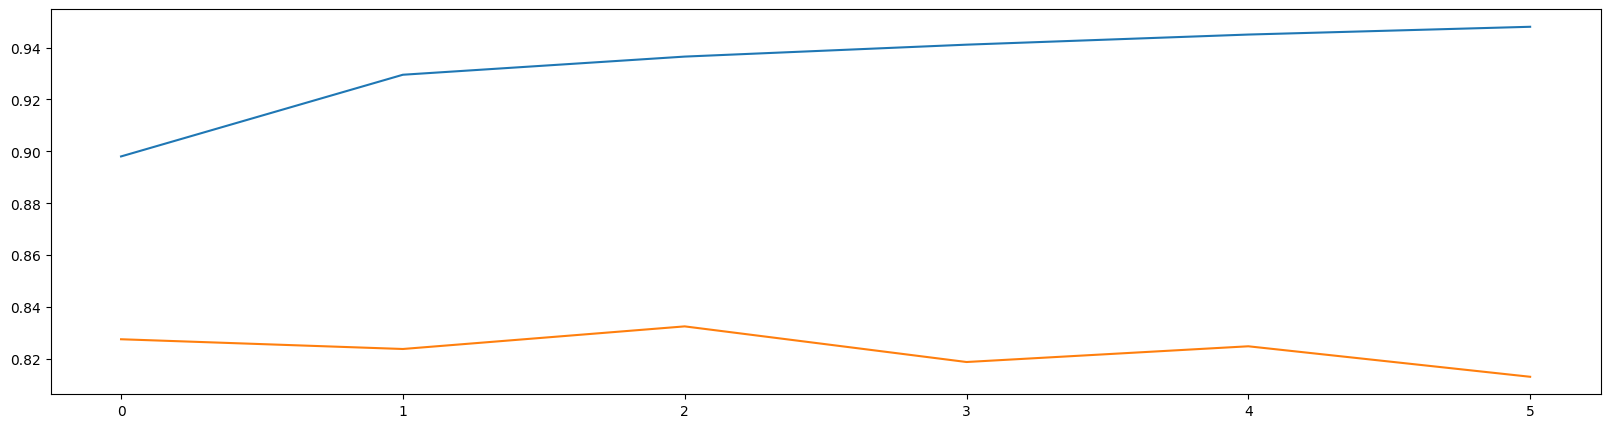

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

Test set: overall $\mathcal{L}$ and accuracy.

In [11]:
model.evaluate(test, test_labels)

15012/15012 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.7498 - loss: 1.5717


[1.5716863870620728, 0.7497559189796448]

In [12]:
predictions = model.predict(test)

15012/15012 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


Confusion matrix: rows = ACTUAL, columns = PREDICTED. Diagonal = correct predictions; off-diagonal = errors. With `normalize="pred"`, each column sums to 1 (precision per predicted class).

In [13]:
predicted_labels = np.argmax(predictions, axis=1)
conf = confusion_matrix(test_labels, predicted_labels, normalize="pred")
conf

array([[7.62241695e-01, 1.23941651e-01, 7.25501721e-02, 7.23937433e-02,
        8.68657675e-02, 9.45945946e-02, 1.60368459e-01, 2.66198772e-01],
       [3.82466501e-02, 7.69254310e-01, 1.25955160e-03, 1.19154860e-02,
        5.82048812e-03, 2.67899478e-02, 3.73453193e-02, 2.93269833e-02],
       [2.81399601e-02, 4.08038356e-04, 8.12242842e-01, 2.81713209e-02,
        8.50995504e-03, 7.96586060e-03, 1.50380112e-02, 0.00000000e+00],
       [2.71265847e-02, 5.10047945e-04, 2.93895373e-04, 8.25935632e-01,
        2.12748876e-03, 2.84495021e-02, 8.60107652e-03, 6.32911392e-03],
       [2.82001010e-02, 8.92583903e-03, 2.29238391e-02, 0.00000000e+00,
        6.65261721e-01, 1.34660977e-02, 1.66139504e-01, 4.07319213e-03],
       [3.40608386e-02, 2.95827808e-03, 2.32597195e-02, 5.88403898e-02,
        3.48025048e-02, 6.96064486e-01, 6.18167693e-02, 0.00000000e+00],
       [4.44682335e-02, 8.24747526e-02, 2.30917793e-03, 3.27573499e-04,
        1.32867694e-02, 1.31247037e-01, 5.48415737e-01, 1.

In [14]:
legend = GESTURE_LABELS

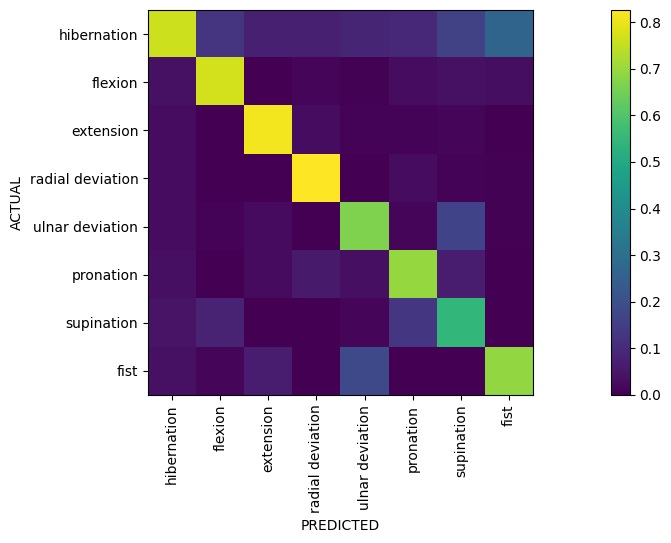

In [15]:
plt.imshow(conf)
plt.ylabel("ACTUAL")
plt.xlabel("PREDICTED")
plt.yticks(np.arange(len(legend)), legend)
plt.xticks(np.arange(len(legend)), legend, rotation='vertical')
plt.colorbar()

Per-class: $\text{Precision}_k = \frac{TP_k}{TP_k+FP_k}$, $\text{Recall}_k = \frac{TP_k}{TP_k+FN_k}$, $\text{F1}_k = 2\frac{P_k R_k}{P_k+R_k}$; support and macro/weighted averages at the bottom.

In [16]:
print(classification_report(test_labels, predicted_labels, target_names=GESTURE_LABELS))

                  precision    recall  f1-score   support

     hibernation       0.76      0.94      0.84    270708
         flexion       0.77      0.50      0.61     29973
       extension       0.81      0.64      0.72     30051
radial deviation       0.83      0.67      0.74     30118
 ulnar deviation       0.67      0.55      0.60     30015
       pronation       0.70      0.49      0.57     30037
      supination       0.55      0.34      0.42     29470
            fist       0.69      0.37      0.48     30007

        accuracy                           0.75    480379
       macro avg       0.72      0.56      0.62    480379
    weighted avg       0.74      0.75      0.73    480379



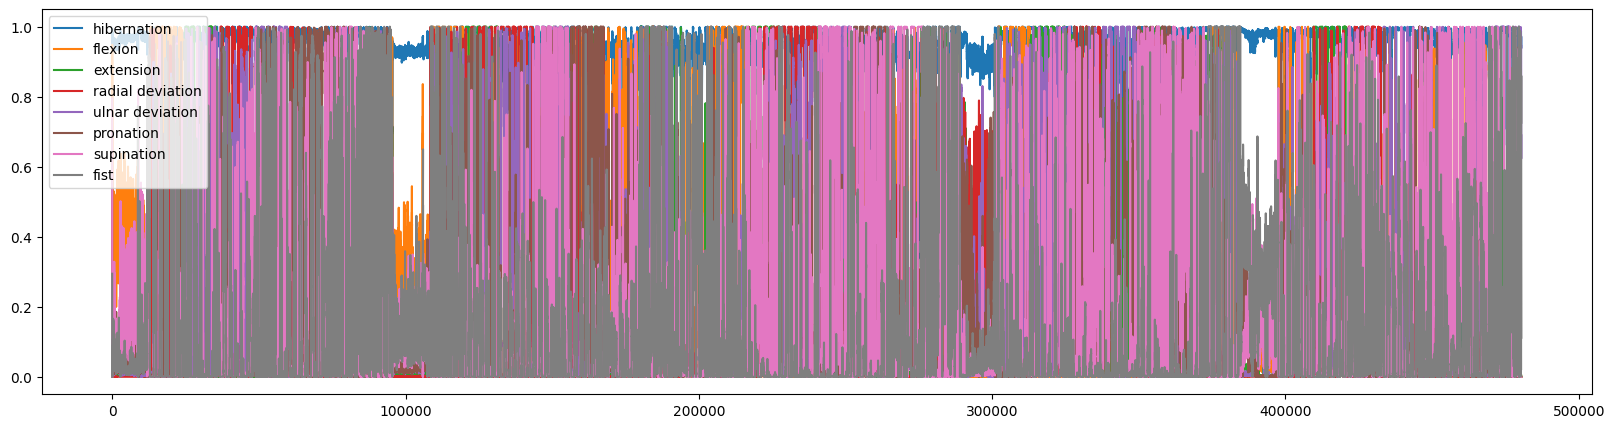

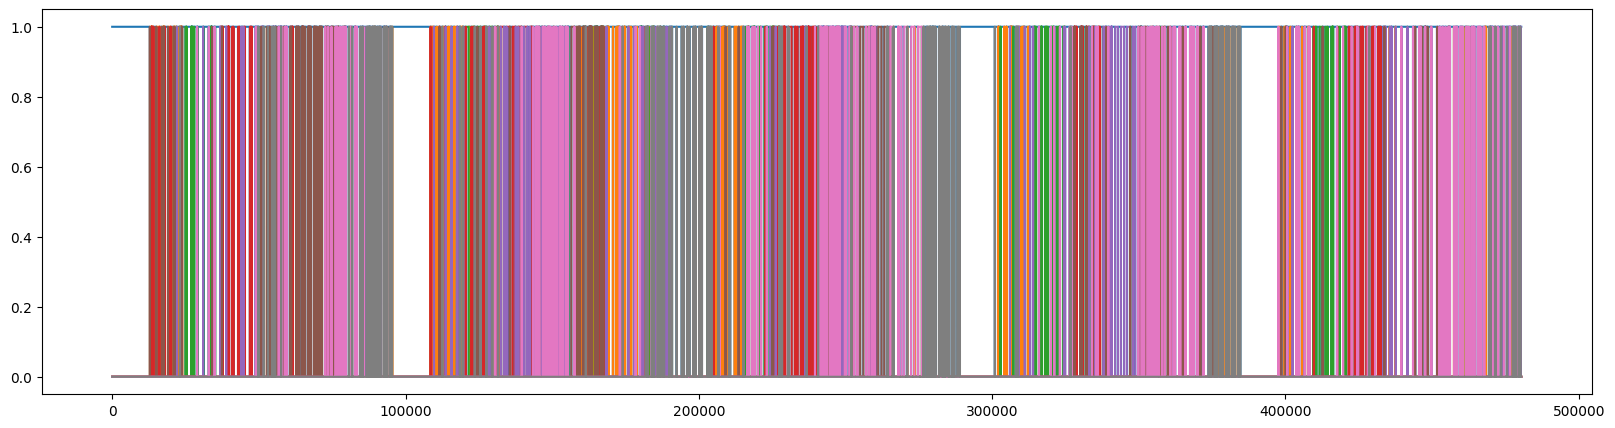

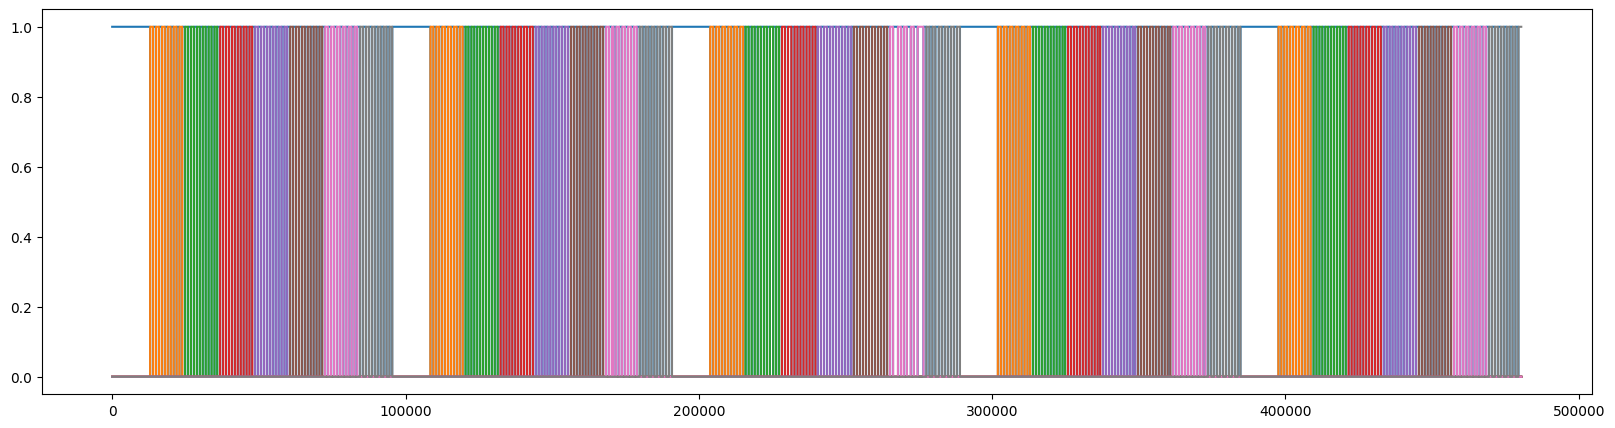

In [17]:
plt.figure()
plt.plot(predictions)
plt.legend(legend, loc = "upper left")

predicted_labels_onehot = keras.utils.to_categorical(predicted_labels, num_classes = NUM_GESTURES)
test_labels_onehot = keras.utils.to_categorical(test_labels, num_classes = NUM_GESTURES)

plt.figure()
plt.plot(predicted_labels_onehot)

plt.figure()
plt.plot(test_labels_onehot)

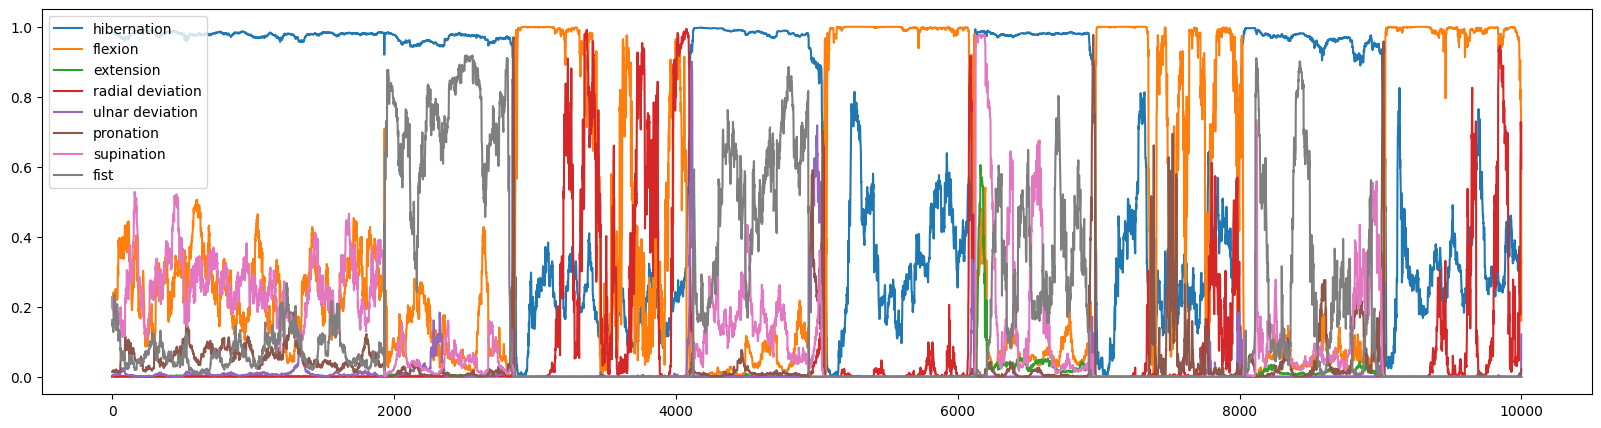

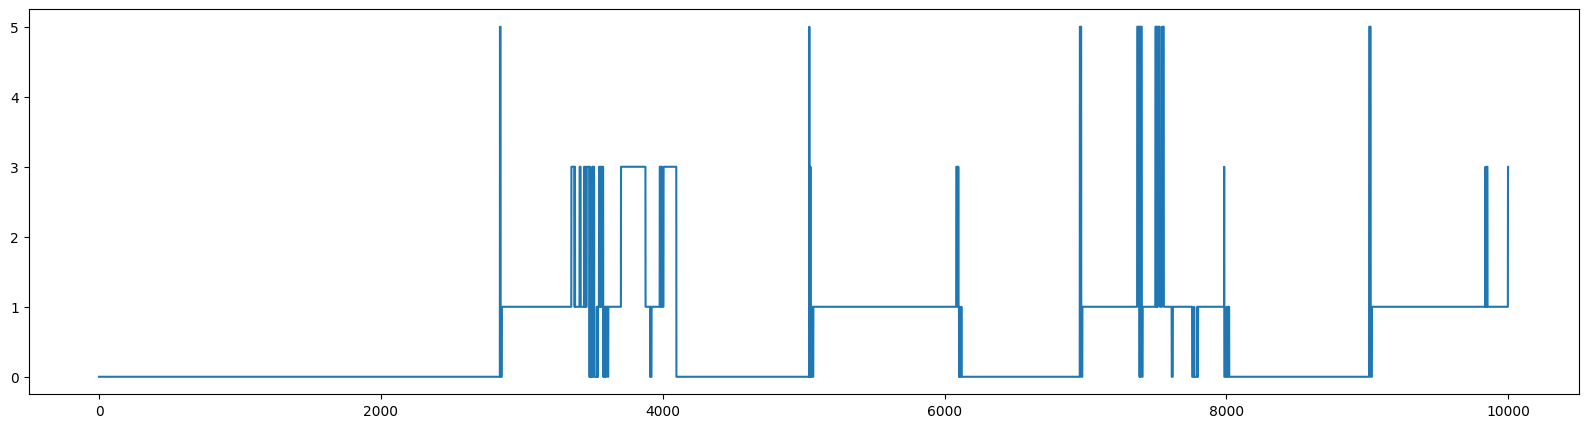

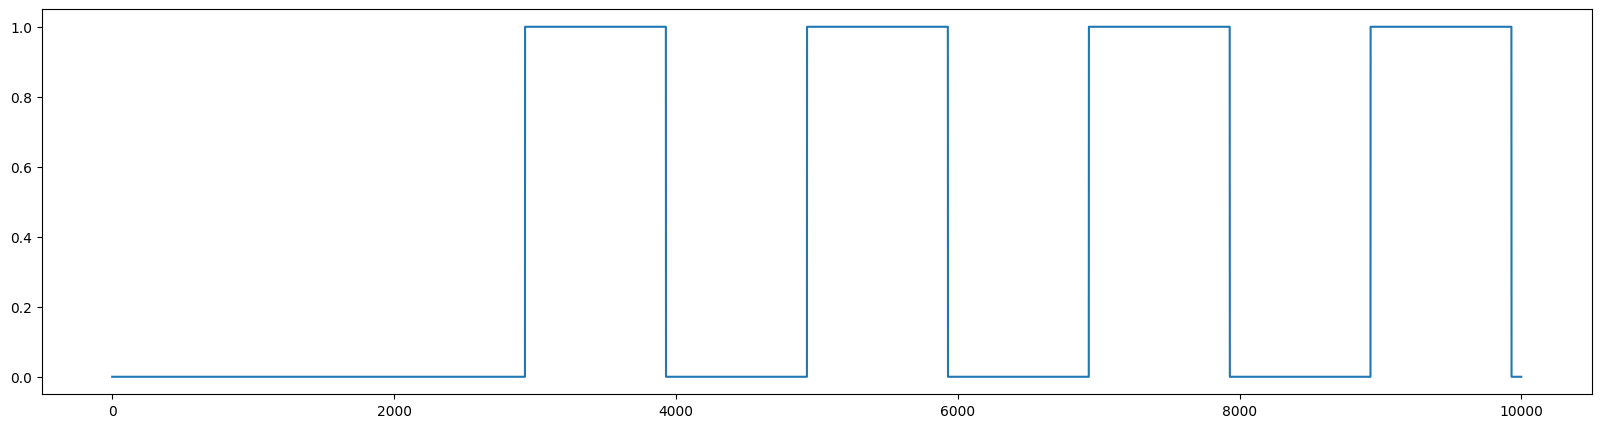

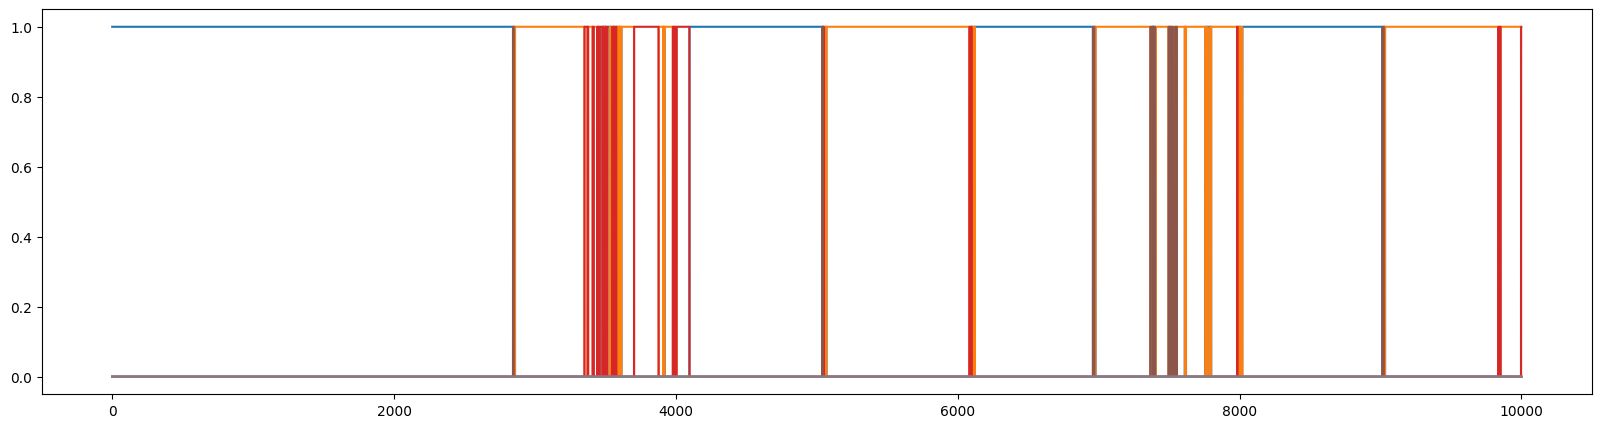

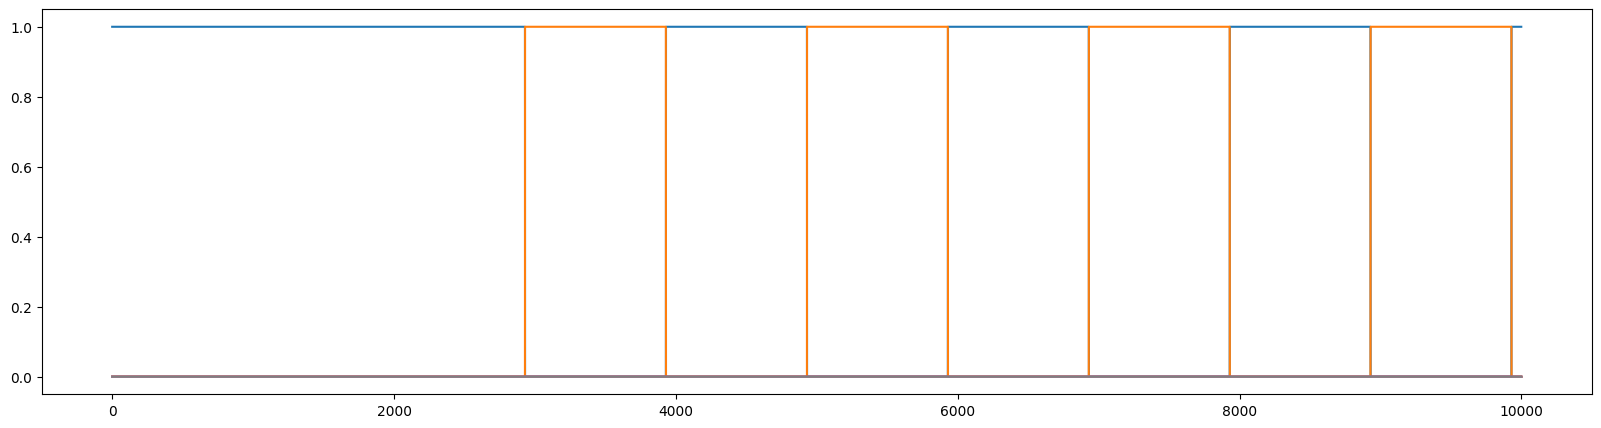

In [18]:
plt.figure()
plt.plot(predictions[10000:20000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(predicted_labels[10000:20000])
plt.figure()
plt.plot(test_labels[10000:20000])
plt.figure()
plt.plot(predicted_labels_onehot[10000:20000])
plt.figure()
plt.plot(test_labels_onehot[10000:20000])

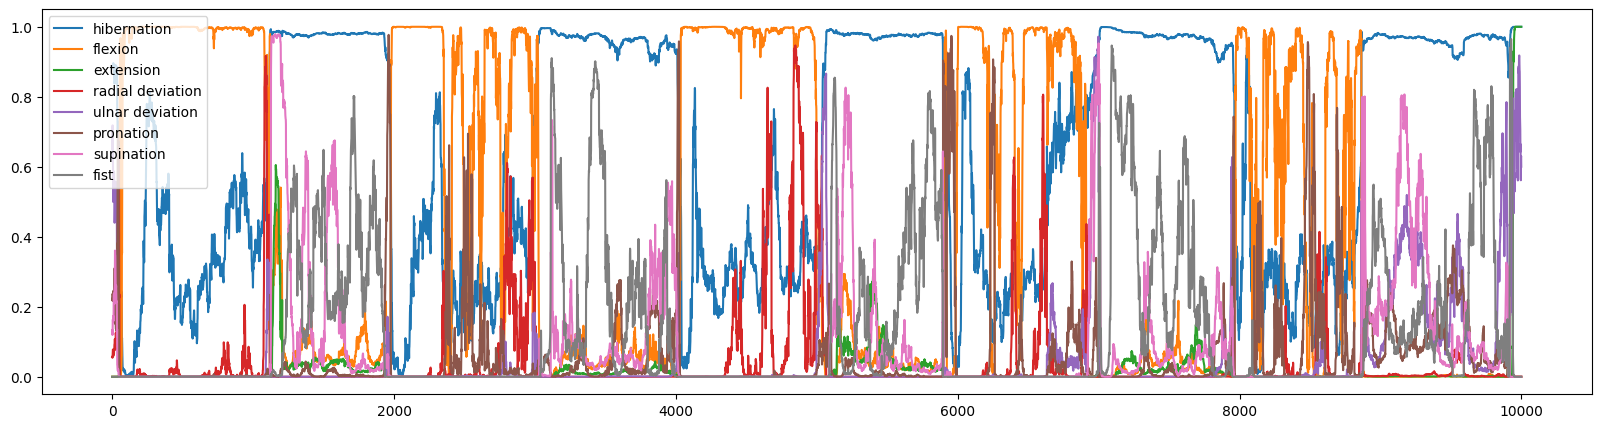

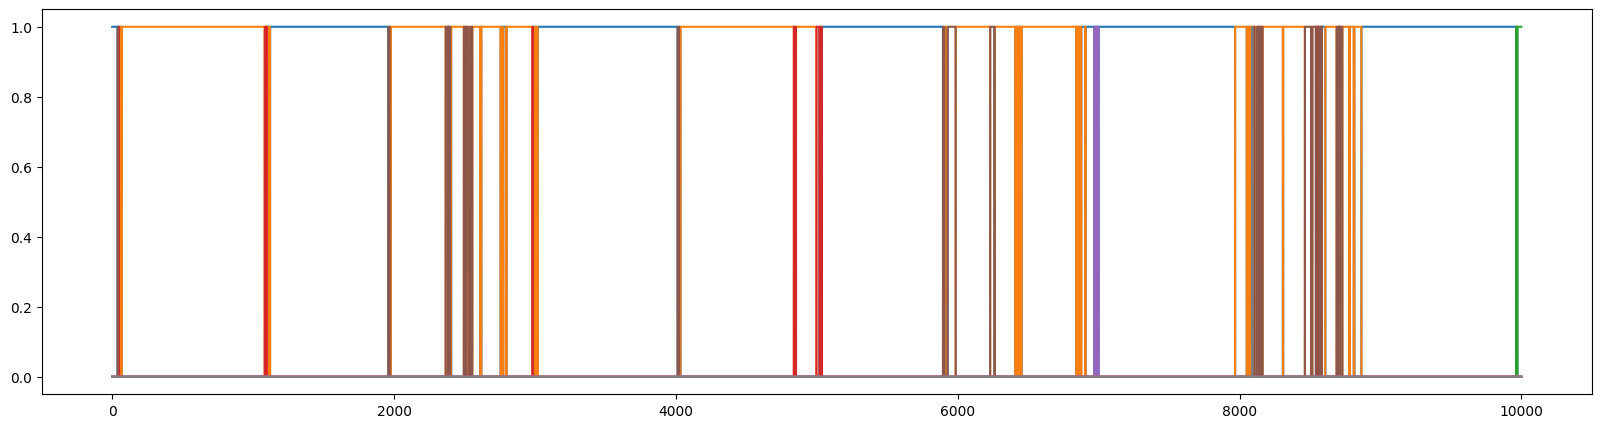

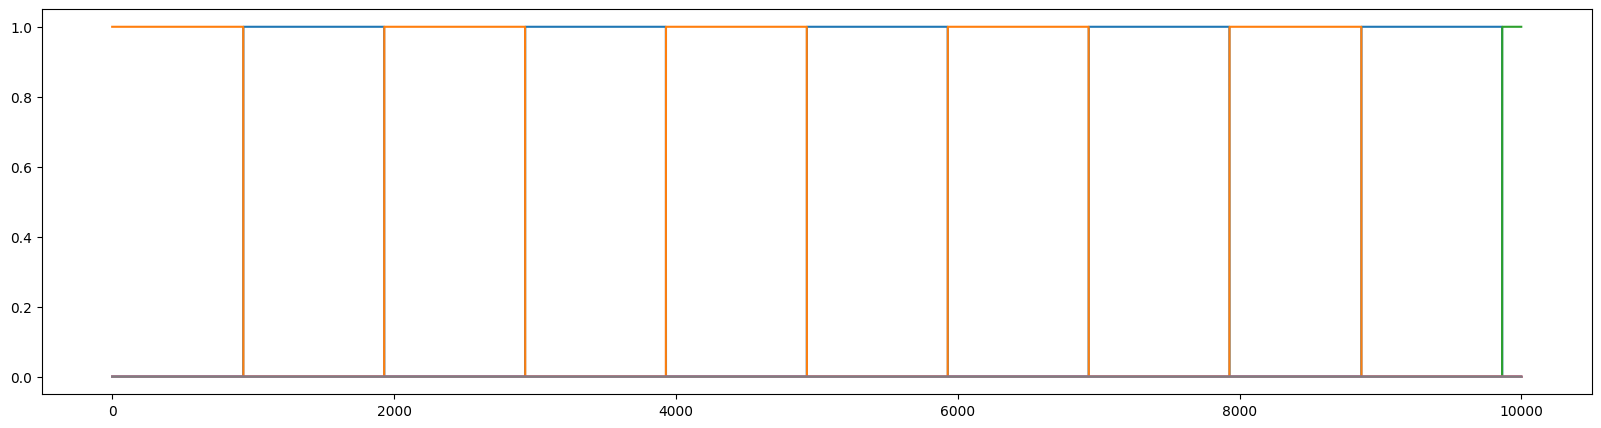

In [19]:
plt.figure()
plt.plot(predictions[15000:25000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(predicted_labels_onehot[15000:25000])
plt.figure()
plt.plot(test_labels_onehot[15000:25000])

In [20]:
training_analysis = model.predict(train)

15028/15028 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


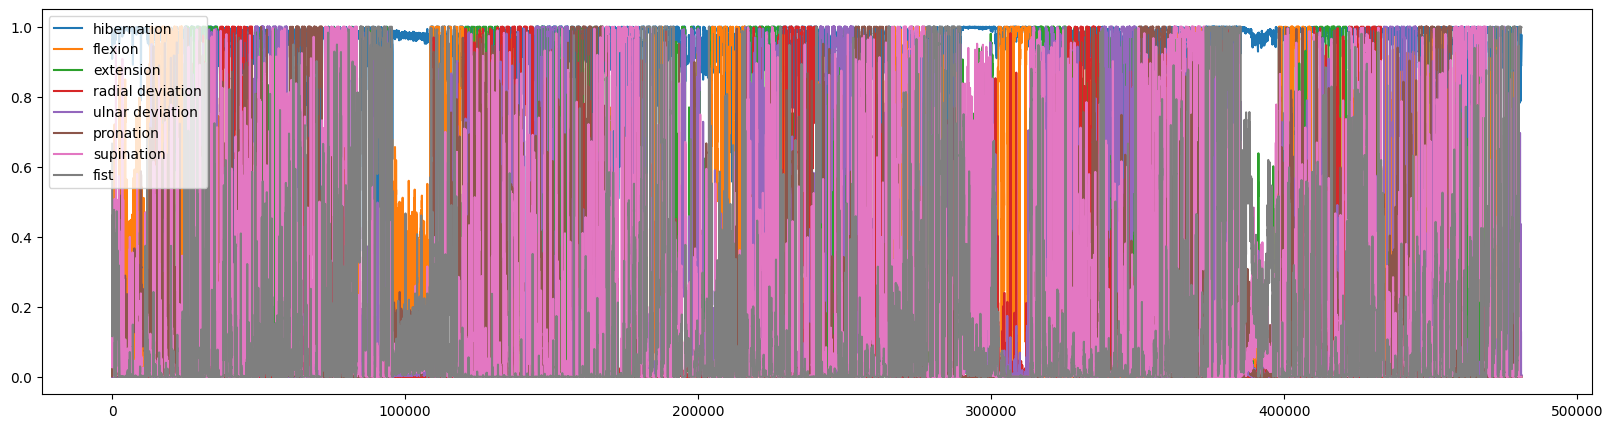

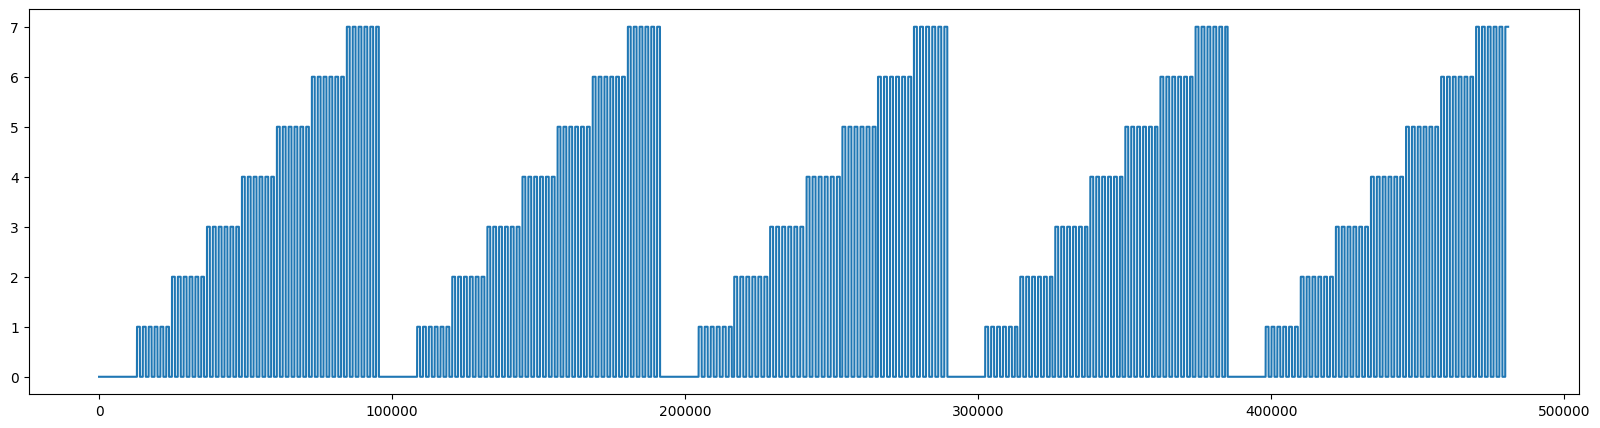

In [21]:
plt.figure()
plt.plot(training_analysis)
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(train_labels)

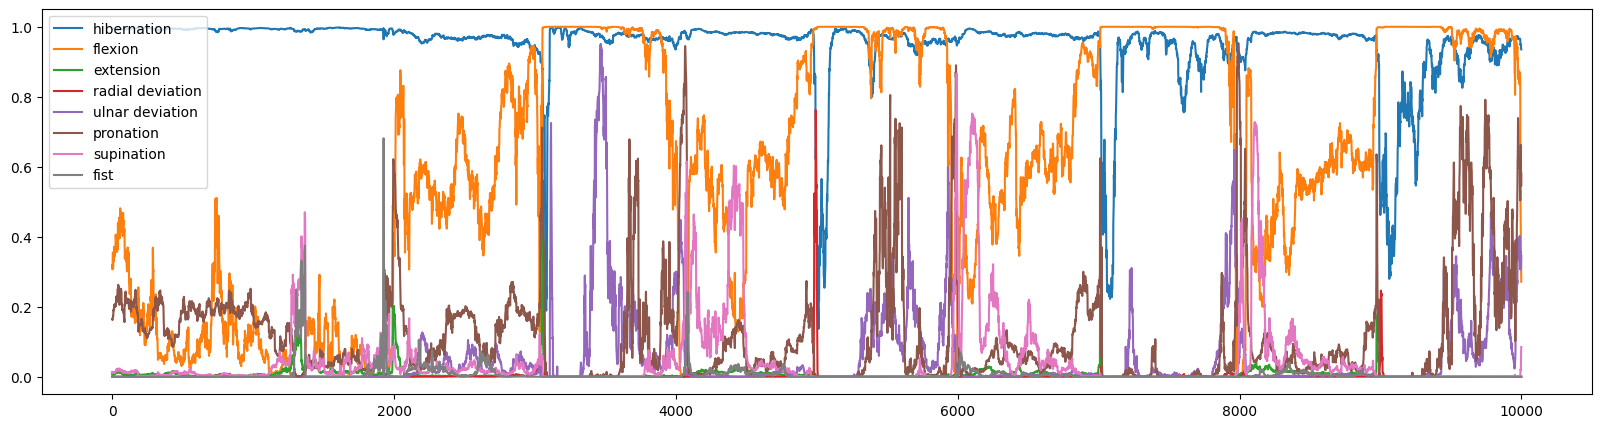

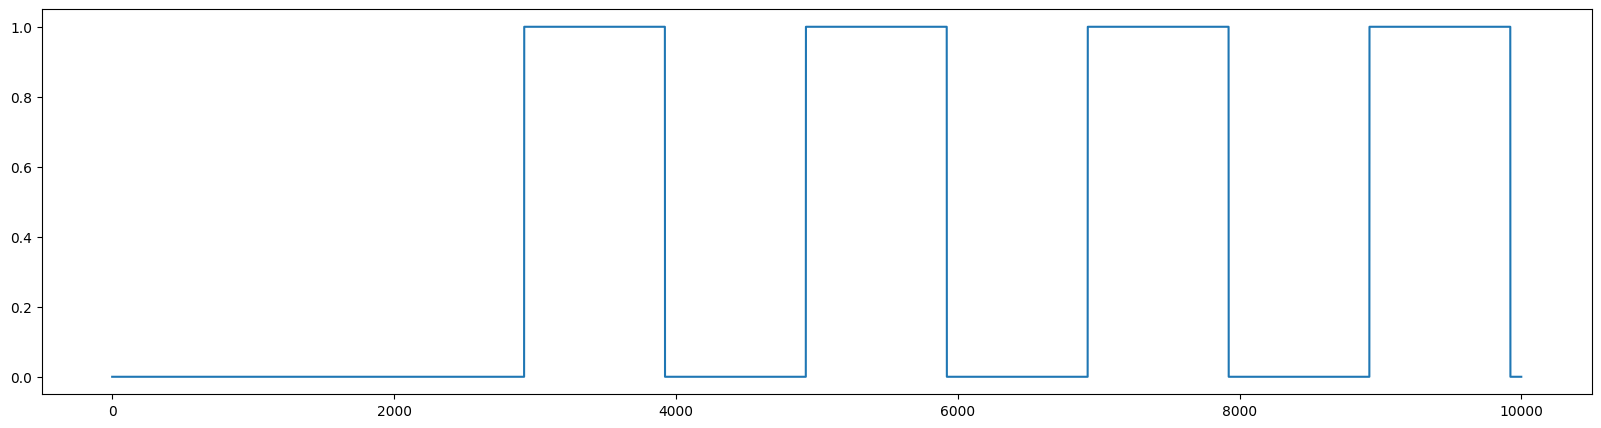

In [22]:
plt.figure()
plt.plot(training_analysis[10000:20000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(train_labels[10000:20000])

## Grokking experiment

Same architecture, many epochs, no early stopping. Goal: observe whether validation accuracy improves late (delayed generalization).

In [23]:
# Grokking attempt: train far past overfitting to look for delayed generalization
grok_model = keras.Sequential([
    keras.layers.Input(shape=(NUM_EMG_CHANNELS,)),
    keras.layers.Dense(LAYER_SIZES[0], activation="relu"),
    keras.layers.Dense(LAYER_SIZES[1], activation="relu"),
    keras.layers.Dense(LAYER_SIZES[2], activation="relu"),
    keras.layers.Dense(NUM_GESTURES, activation="sigmoid")
])
grok_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
grok_history = grok_model.fit(
    train, train_labels,
    validation_data=(valid, valid_labels),
    epochs=GROKKING_EPOCHS
)

Epoch 1/1000
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.8965 - loss: 0.3721 - val_accuracy: 0.8259 - val_loss: 0.6051
Epoch 2/1000
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.9291 - loss: 0.2533 - val_accuracy: 0.8364 - val_loss: 0.6731
Epoch 3/1000
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - accuracy: 0.9366 - loss: 0.2182 - val_accuracy: 0.8249 - val_loss: 0.7505
Epoch 4/1000
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - accuracy: 0.9416 - loss: 0.1951 - val_accuracy: 0.8117 - val_loss: 0.8439
Epoch 5/1000
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.9454 - loss: 0.1781 - val_accuracy: 0.8195 - val_loss: 0.8895
Epoch 6/1000
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.9488 - loss: 0.1647 - val_accuracy: 0.8070 - val_loss: 1.0132
Epoch 7/1000
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.9516 - loss: 0.1542 - val_accuracy: 0.8056 - val_loss: 1.0568
Epoch 8/1000
15028/15028 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/s

Loss and accuracy over all grokking epochs; look for a late rise in validation accuracy.

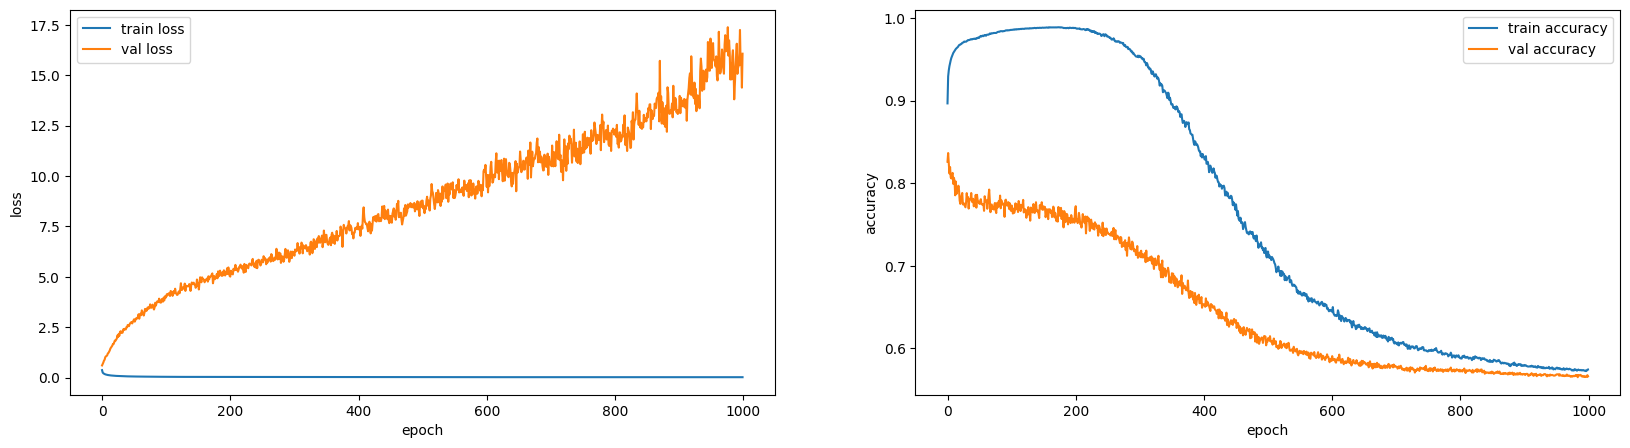

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(grok_history.history["loss"], label="train loss")
ax1.plot(grok_history.history["val_loss"], label="val loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.legend()
ax2.plot(grok_history.history["accuracy"], label="train accuracy")
ax2.plot(grok_history.history["val_accuracy"], label="val accuracy")
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()

In [25]:
grok_model.evaluate(test, test_labels)

15012/15012 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.5667 - loss: 25.9708


[25.970766067504883, 0.5667421221733093]

Test-set confusion matrix for the grokking model (same interpretation: rows = ACTUAL, columns = PREDICTED, normalize=\"pred\" = precision per column).

15012/15012 ━━━━━━━━━━━━━━━━━━━━ 11s 741us/step


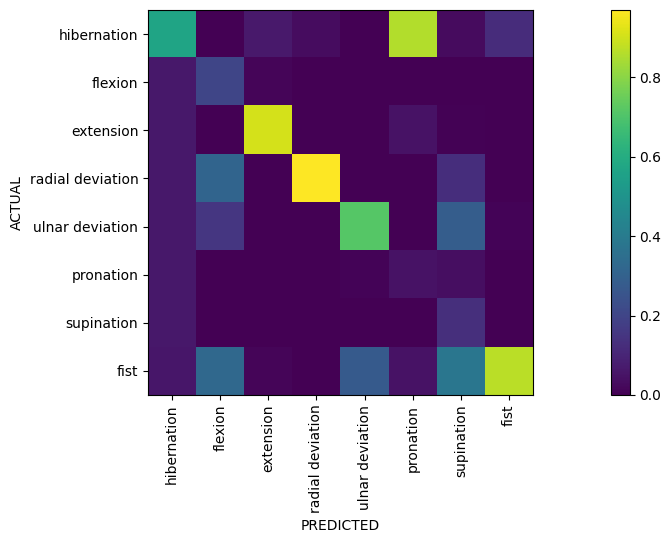

In [26]:
grok_preds = np.argmax(grok_model.predict(test), axis=1)
grok_conf = confusion_matrix(test_labels, grok_preds, normalize="pred")
plt.imshow(grok_conf)
plt.ylabel("ACTUAL")
plt.xlabel("PREDICTED")
plt.yticks(np.arange(len(GESTURE_LABELS)), GESTURE_LABELS)
plt.xticks(np.arange(len(GESTURE_LABELS)), GESTURE_LABELS, rotation="vertical")
plt.colorbar()

Per-class precision, recall, F1 and support; macro and weighted averages at the bottom.

In [27]:
print(classification_report(test_labels, grok_preds, target_names=GESTURE_LABELS))

                  precision    recall  f1-score   support

     hibernation       0.57      1.00      0.72    270708
         flexion       0.20      0.00      0.00     29973
       extension       0.91      0.00      0.00     30051
radial deviation       0.97      0.00      0.00     30118
 ulnar deviation       0.71      0.01      0.03     30015
       pronation       0.05      0.00      0.00     30037
      supination       0.13      0.00      0.00     29470
            fist       0.87      0.04      0.07     30007

        accuracy                           0.57    480379
       macro avg       0.55      0.13      0.10    480379
    weighted avg       0.56      0.57      0.41    480379

